In [2]:
import numpy as np
import nibabel as nib
import glob
#from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

2023-05-06 21:47:38.210990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

In [42]:
############## The following code are for understanding the data only ################

test_image_flair = nib.load(train_path + '/BraTS20_Training_040/BraTS20_Training_040_flair.nii').get_fdata()
print(test_image_flair.max())
scaler = MinMaxScaler()
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
print(test_image_flair.max())


test_image_t1ce = nib.load(train_path + '/BraTS20_Training_040/BraTS20_Training_040_t1ce.nii').get_fdata()

test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)


test_image_t2 = nib.load(train_path + '/BraTS20_Training_040/BraTS20_Training_040_t2.nii').get_fdata()

test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

1200.0
1.0


In [43]:
test_mask=nib.load(train_path + '/BraTS20_Training_040/BraTS20_Training_040_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  

# Since the label 3 is missing, we need to reassign 4 to 3
test_mask[test_mask==4] = 3 
print(np.unique(test_mask))


[0 1 2 4]
[0 1 2 3]


Text(0.5, 1.0, 'mask')

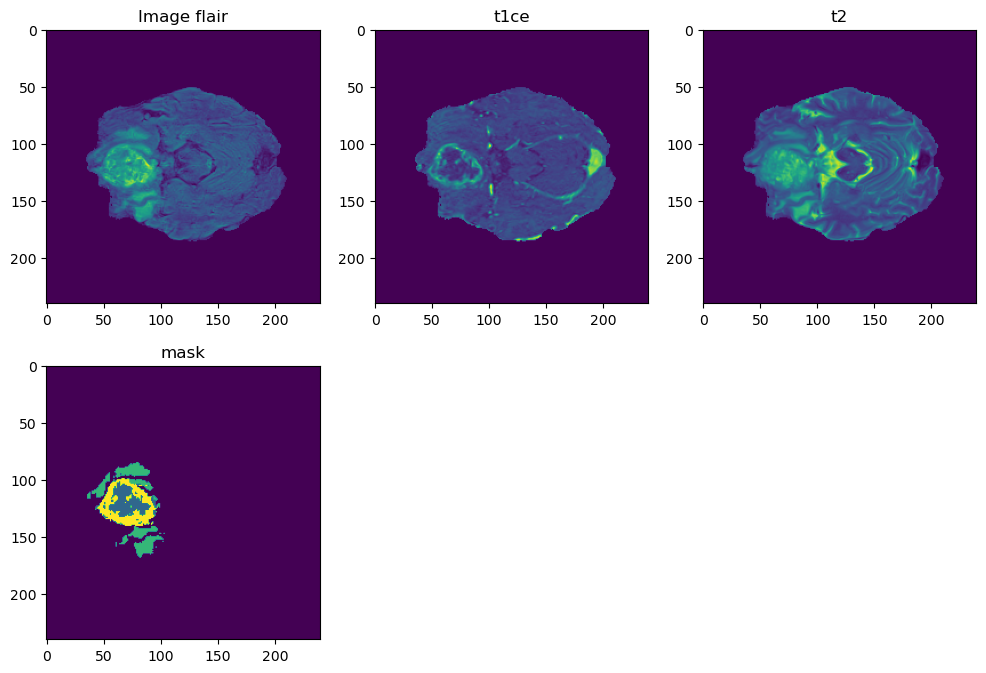

In [53]:
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice])
plt.title('Image flair')

plt.subplot(232)
plt.imshow(test_image_t1ce[:,:,n_slice])
plt.title('t1ce')

plt.subplot(233)
plt.imshow(test_image_t2[:,:,n_slice])
plt.title('t2')

plt.subplot(234)
plt.imshow(test_mask[:,:,n_slice])
plt.title('mask')

In [56]:
'''
The following code are to preprocess the data.
'''

# Group each type of images together into list
t1ce_imgs = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
t2_imgs = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
flair_imgs = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_imgs = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
num_imgs = len(t2_imgs)
print(num_imgs)

125


In [64]:
for i in range(num_imgs):
    # Load matched data using Nifti library
    t1ce = nib.load(t1ce_imgs[i]).get_fdata()
    t2 = nib.load(t2_imgs[i]).get_fdata()
    flair = nib.load(flair_imgs[i]).get_fdata()
    masks = nib.load(mask_imgs[i]).get_fdata()
    
    # Scale
    t1ce = scaler.fit_transform(t1ce.reshape(-1, t1ce.shape[-1])).reshape(t1ce.shape)
    t2 = scaler.fit_transform(t2.reshape(-1, t2.shape[-1])).reshape(t2.shape)
    flair = scaler.fit_transform(flair.reshape(-1, flair.shape[-1])).reshape(flair.shape)
    
    # Assign Numpy type and change label 4 to 3 since label 3 is missing
    masks = masks.astype(np.uint8)
    masks[masks == 4] = 3
    
    # Combine t1ce, tw, flair and discard any files that are unuseful
    imgs = np.stack([flair, t1ce, t2], axis = 3)
    imgs = imgs[56:184, 56:184, 13:141]
    masks = masks[56:184, 56:184, 13:141]
    label_in_img = np.unique(masks, return_counts = True)[0]
    label_count = np.unique(masks, return_counts = True)[1]
    total_count = label_count.sum()
    useful_label_percent = 1 - (label_count[0] / total_count)
    
    if useful_label_percent < 0.01:
        print("Training Set " + str(i) + " Discarded")
    else:
        masks = to_categorical(masks, num_classes = 4)
        np.save('BraTS2020_TrainingData/processed_imgs/train_set_' + str(i) + '.npy', imgs)
        np.save('BraTS2020_TrainingData/processed_masks/mask_' + str(i) + '.npy', masks)
        print(str(i) + " saved")